<a href="https://colab.research.google.com/github/Azka-Yasin/Breast_Cancer_Project_20s20041/blob/main/TransferLearningCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
)
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, Xception
from keras.layers import GlobalAveragePooling2D

# Preprocess images using ImageDataGenerator
def preprocessing_images(path, target_size=(227, 227), augmentation=False):
    if augmentation:
        image_data = ImageDataGenerator(
            zoom_range=0.2,
            shear_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest'
        )
    else:
        image_data = ImageDataGenerator(rescale=1/255)

    image_generator = image_data.flow_from_directory(
        directory=path,
        target_size=target_size,
        batch_size=32,
        class_mode='binary'
    )

    return image_generator

# Function to create a model based on the specified architecture
def create_model(architecture, input_shape):
    if architecture == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif architecture == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported architecture: {architecture}")

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Specify paths
train_path = r"/content/drive/MyDrive/ddsm/train"
test_path = r"/content/drive/MyDrive/ddsm/test"
val_path = r"/content/drive/MyDrive/ddsm/val"

# Data augmentation for training but not for validation set
train_data = preprocessing_images(train_path, target_size=(224, 224), augmentation=True)
val_data = preprocessing_images(val_path, target_size=(224, 224), augmentation=False)

# List of architectures to try
architectures = ['ResNet50', 'Xception']

for architecture in architectures:
    # Model definition
    input_shape = (224, 224, 3)
    model = create_model(architecture, input_shape)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    #early stopping
    es= EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=10, verbose=1, mode='auto')

    # Model checkpoint
    mc = ModelCheckpoint(
        monitor="val_accuracy",
        filepath=f"./21jan-ddsm-bestmodel-{architecture}.h5",
        verbose=1,
        save_best_only=True,
        mode='auto',
        save_freq='epoch'
    )

    # Learning rate scheduler function
    def lr_schedule(epoch):
        learning_rate = 1e-4
        if epoch > 30:
            learning_rate *= 1e-1
        return learning_rate

    # Learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Training
    history = model.fit(
        train_data,
        steps_per_epoch=264,
        epochs=50,
        verbose=1,
        validation_data=val_data,
        validation_steps=57,
        callbacks=[mc, lr_scheduler, es]
    )

    # Save the best model
    model.save(f"/content/drive/MyDrive/models/21jan-ddsm-bestmodel--{architecture}.h5")
    from google.colab import files
    # Download the best model
    files.download(f"/content/drive/MyDrive/models/21jan-ddsm-bestmodel-{architecture}.h5")

    # Visualizations
    # Training vs Validation Loss Graph
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training vs Validation Loss - {architecture}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/ddsm/training_vs_validation_loss_21j_{architecture}.png")
    plt.show()

    # Learning Curve
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy - {architecture}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/ddsm/training_vs_validation_accuracy_21j_{architecture}.png")
    plt.show()


Found 1807 images belonging to 2 classes.
57/57 [==============================] - 10s 165ms/step

Metrics for ResNet:
Accuracy: 0.9862
Precision: 0.9911
Recall: 0.9814
F1 Score: 0.9862
AUC-ROC: 0.9994
Confusion Matrix:
[[887   8]
 [ 17 895]]
Classification Report:
              precision    recall  f1-score   support

      benign     0.9812    0.9911    0.9861       895
   malignant     0.9911    0.9814    0.9862       912

    accuracy                         0.9862      1807
   macro avg     0.9862    0.9862    0.9862      1807
weighted avg     0.9862    0.9862    0.9862      1807



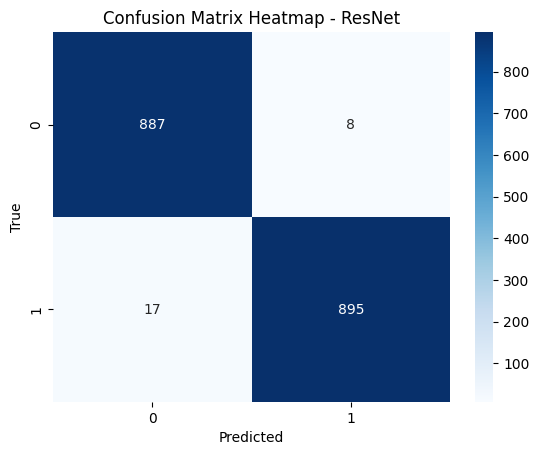

In [8]:
#RESNET
  # Load the best model
model = load_model(f"/content/drive/MyDrive/models/21jan-ddsm-bestmodel-ResNet50.h5")
# Evaluation on the Test Set
# Create an ImageDataGenerator for rescaling
test_data = ImageDataGenerator(rescale=1 / 255)

test_generator = test_data.flow_from_directory(
  directory=test_path,
  target_size=(224, 224),
  batch_size=32,
  class_mode=None,  # Set to None for the test set
  shuffle=False
)

# Calculate the number of steps for evaluation
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# Predictions
y_pred = model.predict(test_generator, steps=test_steps)
y_true = test_generator.classes.astype(float)

# Metrics
accuracy = accuracy_score(y_true, np.round(y_pred))
precision = precision_score(y_true, np.round(y_pred))
recall = recall_score(y_true, np.round(y_pred))
f1 = f1_score(y_true, np.round(y_pred))
auc_roc = metrics.roc_auc_score(y_true, y_pred)

print(f"\nMetrics for ResNet:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, np.round(y_pred))
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, np.round(y_pred), target_names=['benign', 'malignant'], digits=4)
print("Classification Report:")
print(class_report)

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title(f'Confusion Matrix Heatmap - ResNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Found 1807 images belonging to 2 classes.
57/57 [==============================] - 16s 199ms/step

Metrics for Xception:
Accuracy: 0.9817
Precision: 0.9878
Recall: 0.9759
F1 Score: 0.9818
AUC-ROC: 0.9985
Confusion Matrix:
[[884  11]
 [ 22 890]]
Classification Report:
              precision    recall  f1-score   support

      benign     0.9757    0.9877    0.9817       895
   malignant     0.9878    0.9759    0.9818       912

    accuracy                         0.9817      1807
   macro avg     0.9818    0.9818    0.9817      1807
weighted avg     0.9818    0.9817    0.9817      1807



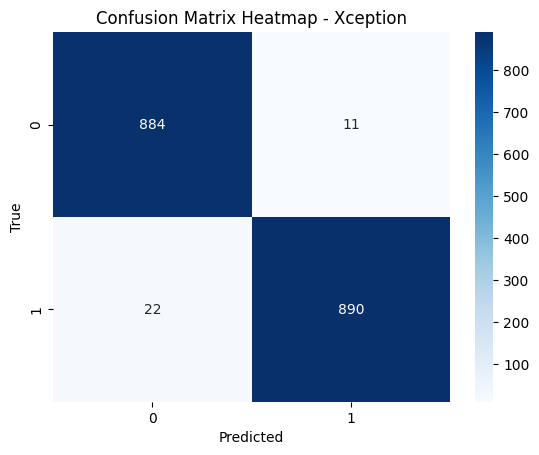

In [10]:
#Xception
  # Load the best model
model = load_model(f"/content/drive/MyDrive/models/21jan-ddsm-bestmodel-Xception.h5")
# Evaluation on the Test Set
# Create an ImageDataGenerator for rescaling
test_data = ImageDataGenerator(rescale=1 / 255)

test_generator = test_data.flow_from_directory(
  directory=test_path,
  target_size=(224, 224),
  batch_size=32,
  class_mode=None,  # Set to None for the test set
  shuffle=False
)

# Calculate the number of steps for evaluation
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# Predictions
y_pred = model.predict(test_generator, steps=test_steps)
y_true = test_generator.classes.astype(float)

# Metrics
accuracy = accuracy_score(y_true, np.round(y_pred))
precision = precision_score(y_true, np.round(y_pred))
recall = recall_score(y_true, np.round(y_pred))
f1 = f1_score(y_true, np.round(y_pred))
auc_roc = metrics.roc_auc_score(y_true, y_pred)

print(f"\nMetrics for Xception:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, np.round(y_pred))
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, np.round(y_pred), target_names=['benign', 'malignant'], digits=4)
print("Classification Report:")
print(class_report)

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title(f'Confusion Matrix Heatmap - Xception')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
